In [11]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 16.0 MB/s eta 0:00:00


In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Parameters
img_height, img_width = 64, 64  # Adjust based on your image size
sequence_length = 7  # Length of sequences for the Transformer
data_dir = '/content/drive/MyDrive/Conv+Transformer Test'

# Load and preprocess images
def load_images(data_dir):
    images = []
    labels = []
    for year in sorted(os.listdir(data_dir)):
        year_path = os.path.join(data_dir, year)
        if os.path.isdir(year_path):
            for img_file in sorted(os.listdir(year_path)):
                if img_file.endswith('.tif'):
                    img_path = os.path.join(year_path, img_file)
                    img = load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
                    img = img_to_array(img) / 255.0
                    images.append(img)
                    labels.append(img)  # Assuming the label is the same image for prediction
    return np.array(images), np.array(labels)


images, labels = load_images(data_dir)

# Check the number of loaded images
print(f"Number of images loaded: {len(images)}")

# Create sequences
def create_sequences(images, sequence_length):
    sequences = []
    targets = []
    for i in range(len(images) - sequence_length):
        sequences.append(images[i:i + sequence_length])
        targets.append(images[i + sequence_length])
    return np.array(sequences), np.array(targets)

sequences, targets = create_sequences(images, sequence_length)

# Check the number of created sequences
print(f"Number of sequences created: {len(sequences)}")

# Split data
if len(sequences) > 0:
    train_sequences, test_sequences, train_targets, test_targets = train_test_split(sequences, targets, test_size=0.2, random_state=42)
    train_sequences, val_sequences, train_targets, val_targets = train_test_split(train_sequences, train_targets, test_size=0.2, random_state=42)

    # Check the sizes of the splits
    print(f"Train sequences: {len(train_sequences)}, Validation sequences: {len(val_sequences)}, Test sequences: {len(test_sequences)}")
else:
    print("No sequences created. Please check the data loading and sequence creation steps.")


Number of images loaded: 87
Number of sequences created: 80
Train sequences: 51, Validation sequences: 13, Test sequences: 16


In [21]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, TimeDistributed, Reshape, UpSampling2D, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

# Custom Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

# CNN Model to extract features from images
def create_cnn(input_shape):
    model = tf.keras.models.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    return model

# Transformer Model
def create_transformer_model(input_shape):
    cnn = create_cnn(input_shape)

    input_seq = Input(shape=(sequence_length, *input_shape))
    x = TimeDistributed(cnn)(input_seq)

    x = transformer_block(x, head_size=128, num_heads=4, ff_dim=256, dropout=0.1)

    x = Dense(64, activation='relu')(x)
    x = Flatten()(x)  # Flatten before reshaping
    x = Dense(input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(x)
    output = Reshape((input_shape[0], input_shape[1], input_shape[2]))(x)

    model = Model(inputs=input_seq, outputs=output)
    return model

input_shape = (img_height, img_width, 1)  # Example input shape
model = create_transformer_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.RSquare()])

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 7, 64, 64, 1)]       0         []                            
                                                                                                  
 time_distributed_5 (TimeDi  (None, 7, 4608)              92672     ['input_6[0][0]']             
 stributed)                                                                                       
                                                                                                  
 layer_normalization_10 (La  (None, 7, 4608)              9216      ['time_distributed_5[0][0]']  
 yerNormalization)                                                                                
                                                                                            

In [22]:
# Train the model
history = model.fit(train_sequences, train_targets, epochs=10, batch_size=16, validation_data=(val_sequences, val_targets))

# Evaluate the model
metrics = model.evaluate(test_sequences, test_targets)
print(f"Test Metrics: {metrics}")


Epoch 1/10
4/4 [==============================] - 6s 335ms/step - loss: 0.2162 - mean_absolute_error: 0.3859 - root_mean_squared_error: 0.4650 - r_square: -1.2008 - val_loss: 0.0592 - val_mean_absolute_error: 0.0834 - val_root_mean_squared_error: 0.2432 - val_r_square: -0.0664
Epoch 2/10
4/4 [==============================] - 0s 31ms/step - loss: 0.0462 - mean_absolute_error: 0.0878 - root_mean_squared_error: 0.2149 - r_square: -0.2173 - val_loss: 0.0256 - val_mean_absolute_error: 0.0265 - val_root_mean_squared_error: 0.1600 - val_r_square: nan
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 0.0223 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.1495 - r_square: nan - val_loss: 0.0246 - val_mean_absolute_error: 0.0247 - val_root_mean_squared_error: 0.1569 - val_r_square: nan
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 0.0215 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.1466 - r_square: nan - val_loss: 0.0246 - v

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_true = test_targets.reshape((test_targets.shape[0], -1))  # Flatten the targets
y_pred = predictions.reshape((predictions.shape[0], -1))  # Flatten the predictions

# Ensure y_true and y_pred have the same number of samples
print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R-squared: {r2}")


y_true shape: (16, 4096), y_pred shape: (16, 4096)
MSE: 0.0190887451171875, MAE: 0.0190887451171875, RMSE: 0.03955882787704468, R-squared: 0.8602270342504718


1/1 [==============================] - 0s 24ms/step


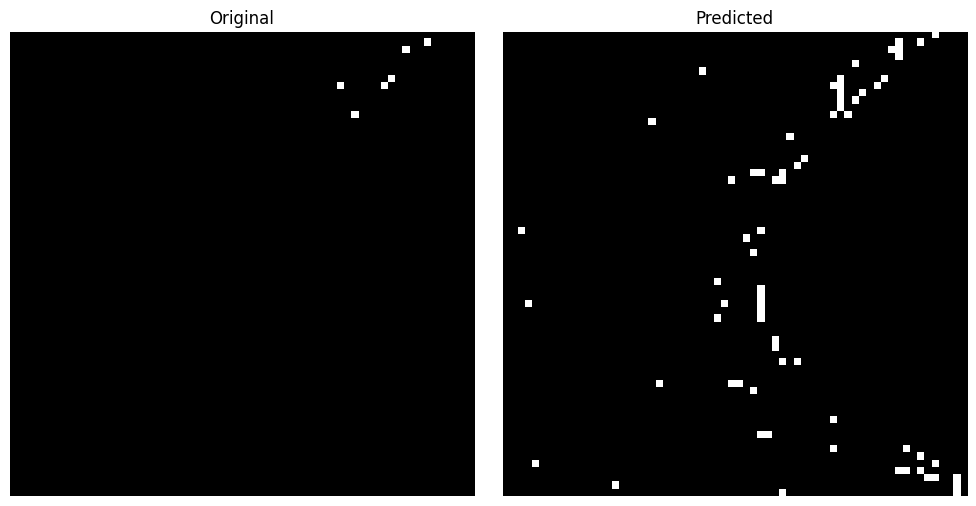

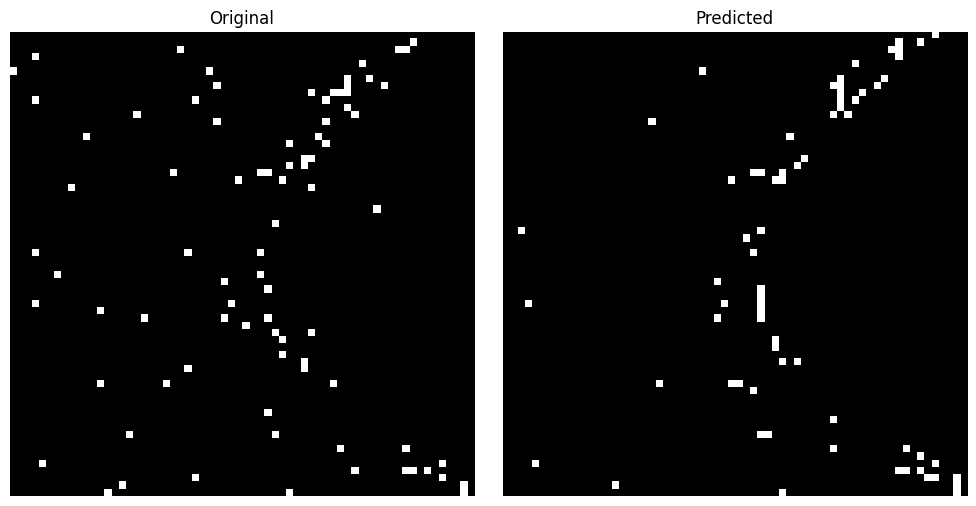

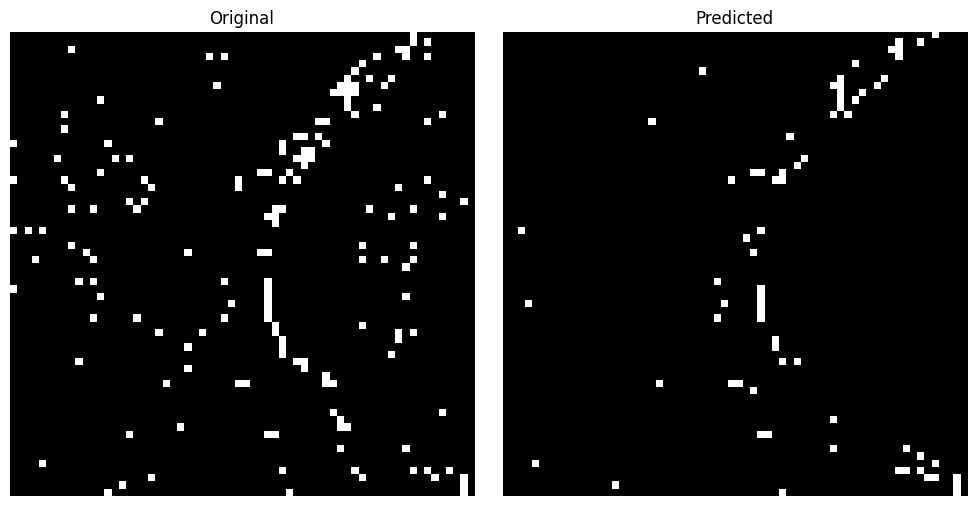

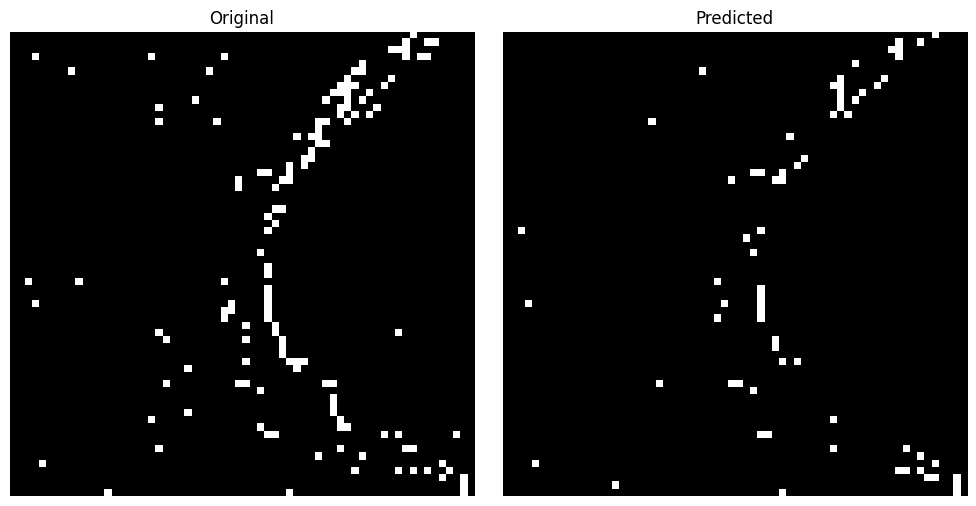

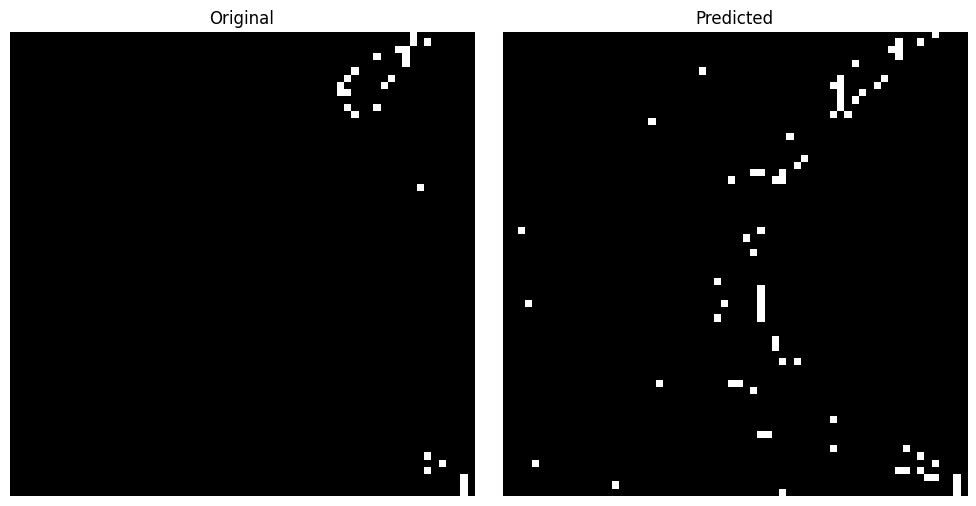

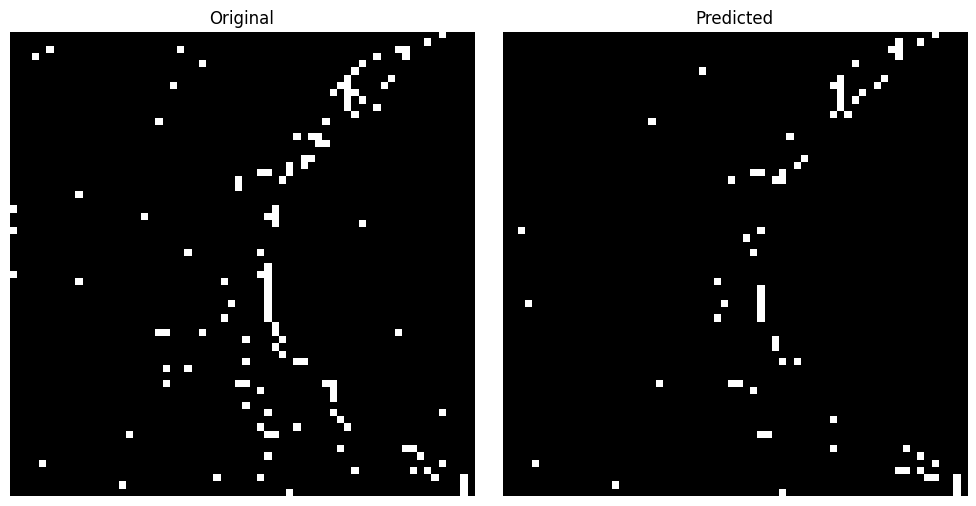

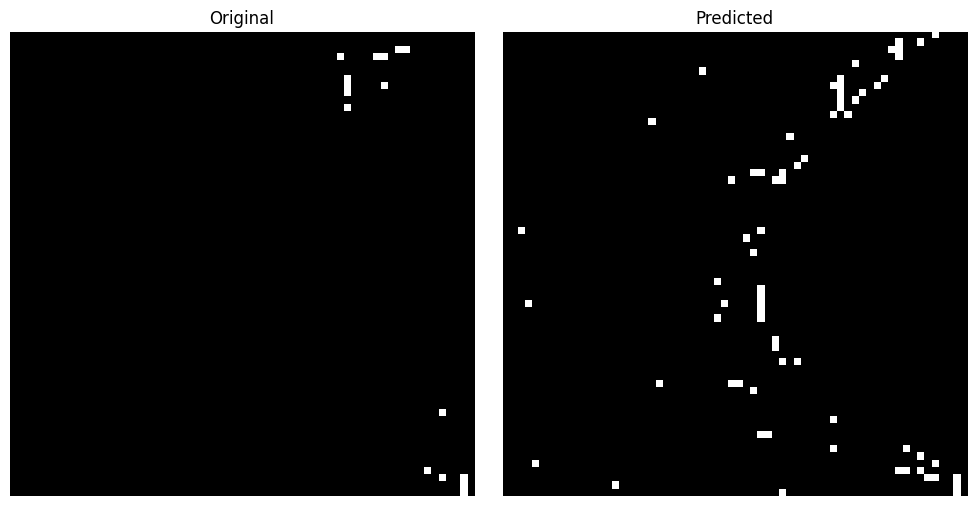

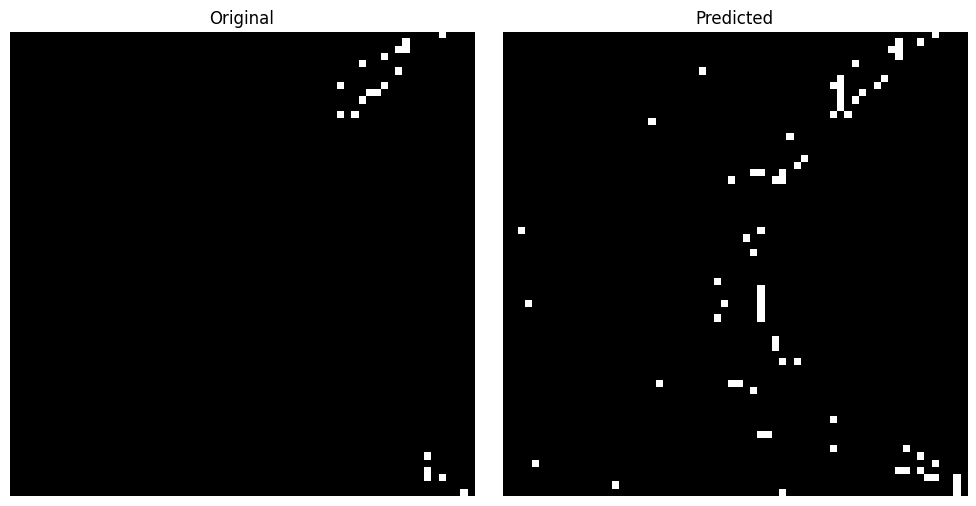

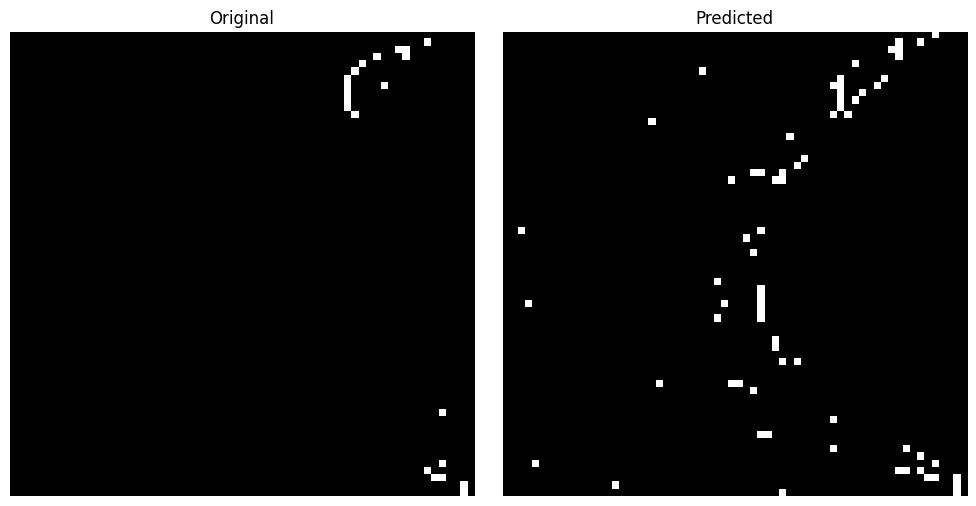

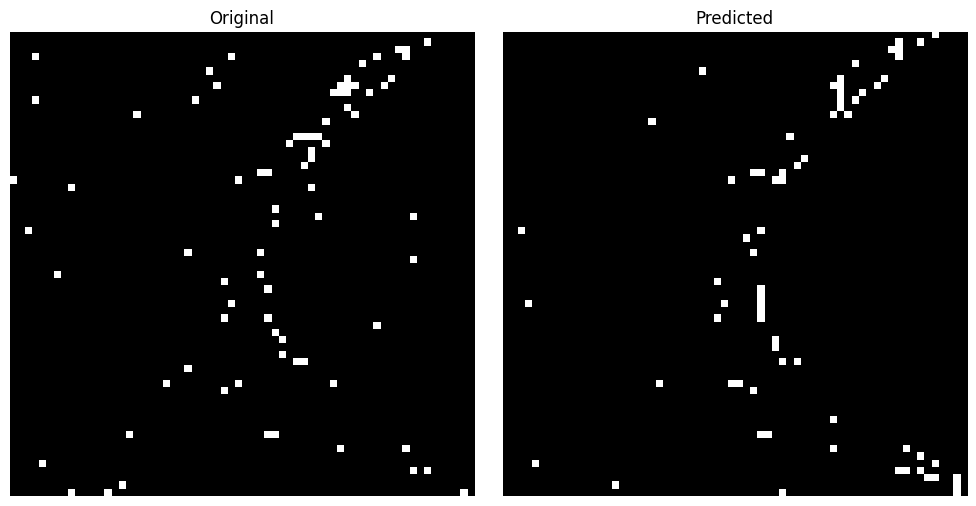

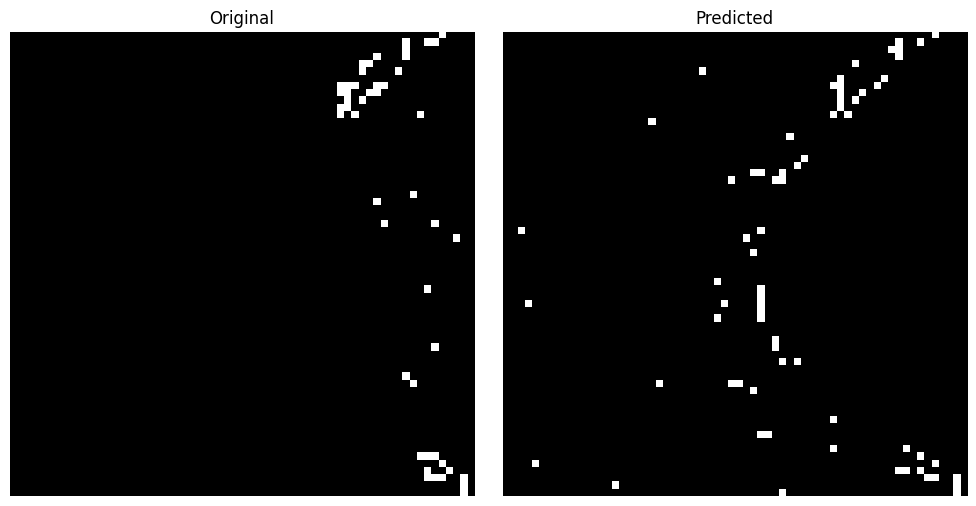

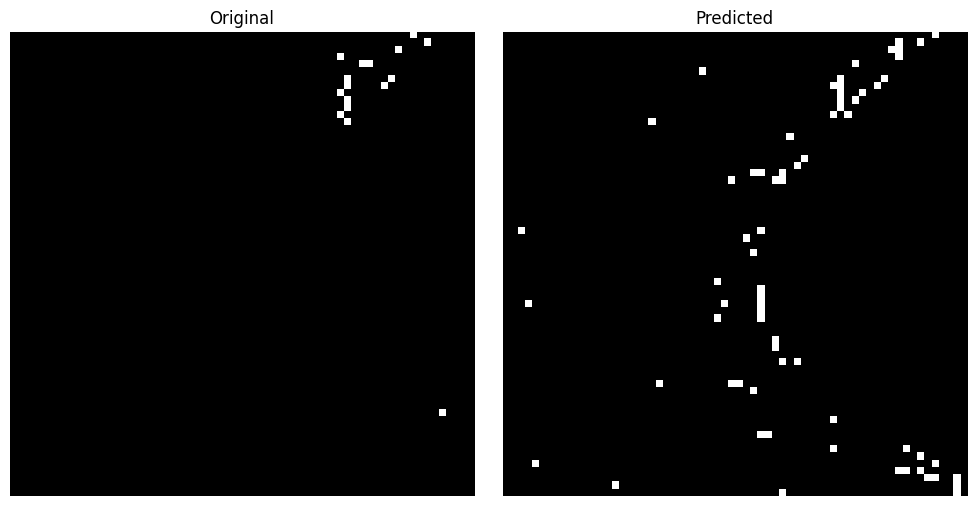

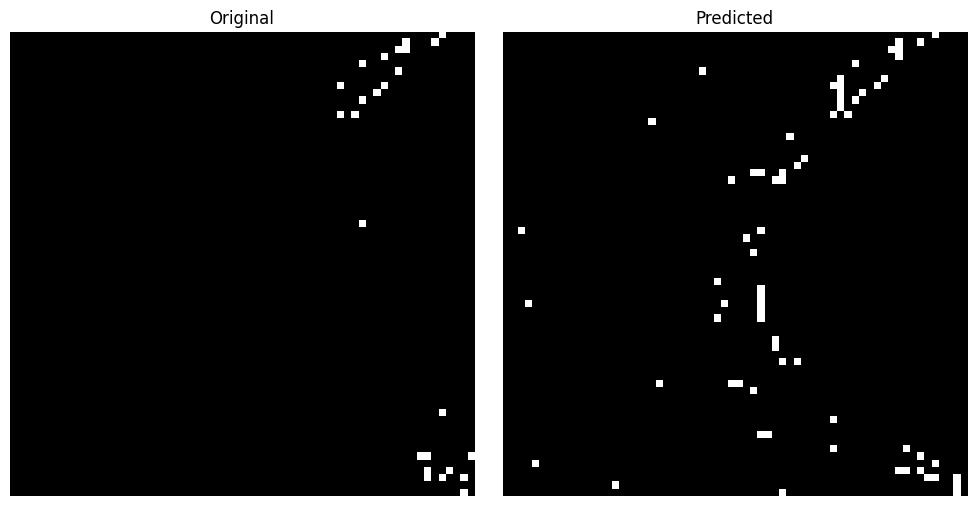

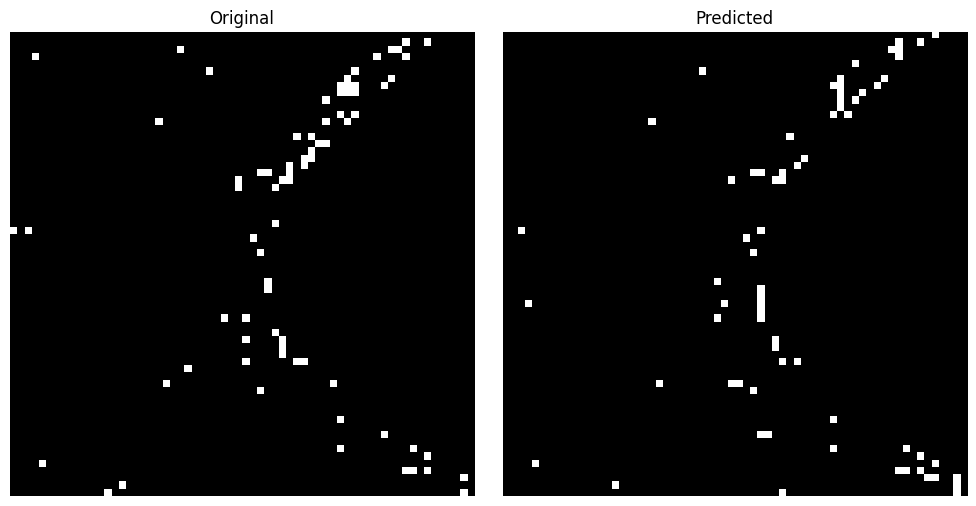

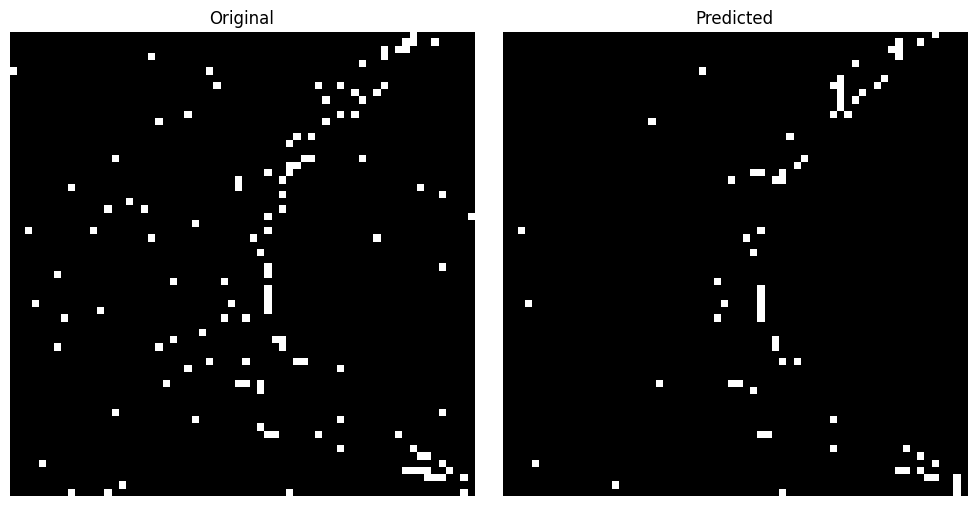

In [27]:
# # Make predictions
# predictions = model.predict(test_sequences)

# # Display original and predicted images
# num_images = min(len(test_targets),  15)
# plt.figure(figsize=(15, 6))
# for i in range(num_images):
#     # Original image
#     plt.subplot(2, num_images, i + 1)
#     plt.imshow(test_targets[i].squeeze(), cmap='gray')
#     plt.title("Original")
#     plt.axis('off')

#     # Predicted image
#     plt.subplot(2, num_images, i + 1 + num_images)
#     plt.imshow(predictions[i].squeeze(), cmap='gray')
#     plt.title("Predicted")
#     plt.axis('off')

# plt.show()



import matplotlib.pyplot as plt

# Make predictions
predictions = model.predict(test_sequences)

# Display original and predicted images separately
num_images = min(len(test_targets), 15)  # Ensure we don't exceed the available test images

for i in range(num_images):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(test_targets[i].squeeze(), cmap='gray')
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Predicted image
    axes[1].imshow(predictions[i].squeeze(), cmap='gray')
    axes[1].set_title("Predicted")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()
